<a href="https://colab.research.google.com/github/TK-Problem/Python-mokymai/blob/master/Scripts/cvbankas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Importuoti paketus

# playwright biblioteka naudojama importuoti html kodą
!pip install playwright==1.25.00
!playwright install-deps
!playwright install webkit
!pip install nest_asyncio

# playwright veikia TIK asyncio režimu
import nest_asyncio
nest_asyncio.apply()
import asyncio

# importuoti playwright versiją
from playwright.async_api import async_playwright

# bs4 naudojama iš HTML ištraukti reikiamą informaciją
from bs4 import BeautifulSoup

# kartais reikia palaikyti kurį laiką programą veikiančią
import time

# paketai dirbti su skaičiais ir duomenimis
import pandas as pd
import numpy as np

# biblioteka skirta sugeneruoti žodžių debesiui
from wordcloud import WordCloud

# stacionarūs paveiksliukai
import matplotlib.pyplot as plt

# clear output komanda naudojama išvalyti informacijai
from IPython.display import clear_output
clear_output()

# Duomenų atsisiuntimas

Funcijos veikimo žingsniai:

* sukuria `playwright` webdriver'į (webkit),
* sukuria netikrą `user_agent`, kad svetainė tave laikytų tikru varotoju,
* sugeneruoji `cvbankas.lt` puslapio URL kartu su raktažodžių (keyword),
* paspaudžia ant pop-up ir cookie mygtukų,
* palaukia prevenciškai palaukia 2 sekundes,
* atsisiunčia HTML kodą,
* perkelia jį į `BeautifulSoup` objektą,
* iteruojame per eilutes ir išsitraukiame reikiamą informaciją,
* duomenis sukeliame į `pandas` DataFrame objektą ir jį grąžiname.

In [2]:
#@title CVbankas funkcija
async def cvbankas(keyword="python"):
    """
    This function returns all available job listings based on search keyword.
    Inputs:
      keyword (str)
    Output:
      returns pandas DataFrame
    """
    async with async_playwright() as p:

        # create webdriver/webkit
        browser = await p.webkit.launch()

        # create user agent for the webdriver
        user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:95.0) Gecko/20100101 Firefox/95.0'

        # create new page, i.e. new table in your browser
        page = await browser.new_page(user_agent=user_agent)
        
        # generate URL with a keyword
        url = f"https://www.cvbankas.lt/?location=&padalinys%5B%5D=&keyw={keyword}"
        
        # visit page
        await page.goto(url)

        # click cookie button
        await page.click("//button[@id='onetrust-accept-btn-handler']")

        # imlicit wait
        time.sleep(2)

        # get page html contents
        page_source = await page.content()

        # convert to bs4 object
        soup = BeautifulSoup(page_source, "lxml")

        # get search results, i.e. each row new job ad
        rows = soup.find("div", {"id": "js_id_id_job_ad_list"}).find_all("article")

        # create tmp. list to store data
        lst = list()

        # iterate over all rows
        for row in rows:
          # get cells with job add data
          cells = row.find_all("div", {"class": "list_cell"})

          # employer info
          employer = cells[0].find("span", {"class": "dib mt5"}).text
          job_title = cells[0].h3.text

          # get salary
          try:
            salary = cells[1].find("span", {"class": "salary_amount"}).text
            salary += cells[1].find("span", {"class": "salary_period"}).text
            salary_type = cells[1].find('span', {'class': 'salary_calculation'}).text
          except:
            salary = ''
            salary_type= ''

          # location
          try:
            location = cells[2].find("span", {"class": "list_city"}).text
          except:
            location = ''

          # add data
          lst.append([employer, job_title, location, salary_type, salary])

        # save image to your enviroment (for debuging)
        # one can close this line
        await page.screenshot(path="cvbankas_status.png")
        
        # close webkit
        await browser.close()

        # return pandas DataFrame
        return pd.DataFrame(lst, columns = ['Employer', 'JobTitle', "Location", "SalaryType", "Salary"])

In [3]:
#@title Atsisiųsti duomenis
# paieškos žodis
keyword = 'python' # @param {type:"string"}

# iškviečiame funkciją ir išsaugome duomenis ir atvaizduojame pirmus 5 skelbimus
df_cvbankas = asyncio.run(cvbankas(keyword))

# parašyti kiek rado skelbimų
print(f"Rado {len(df_cvbankas)} skelbimų pagal {keyword} raktažodį.")

df_cvbankas.head()

Rado 43 skelbimų pagal python raktažodį.


,Employer,JobTitle,Location,SalaryType,Salary
0,Ignitis grupė,JUNIOR PORTFOLIO MANAGER (F/M/D),Vilniuje,Neatskaičius mokesčių,2652-3979€/mėn.
1,Eleving Vehicle Finance AS,Data Analyst,Vilniuje,Neatskaičius mokesčių,2200-2800€/mėn.
2,UAB „Nanoavionics“,Environmental Test Engineer,Vilniuje,Neatskaičius mokesčių,Nuo 2000€/mėn.
3,Ignitis grupė,RPA DEVELOPER (2 YEARS FIXED TERM CONTRACT) (F...,Vilniuje,Neatskaičius mokesčių,2333-3500€/mėn.
4,UAB „FESTO“,Junior Client Application Specialist,Kaune,Neatskaičius mokesčių,Nuo 1300€/mėn.


# Duomenų apdorojimas

Duomenis būtina sutvarkyti prieš pradedant analizuoti. Atlyginimo stulpelis `salary` turi keletą tipų reikšmių:

* vieni atlyginimai parašyti per ruožą, pvz. € 3300 – 4000. Tokiu atveju, reikia ištraukti minimalią ir maksimalią atlyginimo vertes, panaikinti euro simbolį.
* kiti skelbimai neskelbia atlygimų, tiesiog rašo "TOP Darbdavys". Tokius įrašus reikia paversti NaN vertėmis.
* yra atlyginimų, kur rašo valandinį, pvz. € 6/h, tokiu šį atlyginimą paversti į mnesinį.

Galiausiai atlyginimai yra sunormuojami į vidurkį tarp minimalaus ir maksimalaus siūlomo varianto.

In [4]:
#@title Sutvarkyti skaitinius duomenis
def clean_num_cols(df):
  """
  Formats salary columns
  Input:
    df - pandas DataFrame
  Output:
    pandas DataFrame
  """  
  # get min salary if "Nuo " condition is present
  cond_1 = df.Salary.apply(lambda x: "Nuo " in x)
  df.loc[cond_1, 'SalaryMin'] = df.loc[cond_1, 'Salary'].apply(lambda x: x.split(" ")[1][:-6])

  # get max salary if "Iki " condition is present
  cond_2 = df.Salary.apply(lambda x: "Iki " in x)
  df.loc[cond_2, 'SalaryMax'] = df.loc[cond_2, 'Salary'].apply(lambda x: x.split(" ")[1][:-6])

  # get salarys for add with min and max values
  df.loc[~(cond_1 | cond_2), 'SalaryMin'] = df.loc[~(cond_1 | cond_2), 'Salary'].apply(lambda x: x.split("-")[0])
  df.loc[~(cond_1 | cond_2), 'SalaryMax'] = df.loc[~(cond_1 | cond_2), 'Salary'].apply(lambda x: x.split("-")[1][:-6] if len(x.split("-"))==2 else np.nan)

  # fill missing values with np.nan
  df['SalaryMin'].fillna(np.nan, inplace = True)
  df.loc[df.SalaryMin == "", 'SalaryMin'] = np.nan

  # convert to floats
  df['SalaryMin'] = df['SalaryMin'].astype(float)
  df['SalaryMax'] = df['SalaryMax'].astype(float)

  # calculate average salary
  df['SalaryMean'] = df[['SalaryMin', 'SalaryMax']].mean(axis=1)
  
  # return cleaned DataFrame
  return df

In [5]:
# clean numerical values
df_c = clean_num_cols(df_cvbankas.copy())

# drop ads without salary
df_c = df_c.loc[~df_c.SalaryMean.isna()].reset_index(drop=True)

# return first 5 adds
df_c.head()

,Employer,JobTitle,Location,SalaryType,Salary,SalaryMin,SalaryMax,SalaryMean
0,Ignitis grupė,JUNIOR PORTFOLIO MANAGER (F/M/D),Vilniuje,Neatskaičius mokesčių,2652-3979€/mėn.,2652.0,3979.0,3315.5
1,Eleving Vehicle Finance AS,Data Analyst,Vilniuje,Neatskaičius mokesčių,2200-2800€/mėn.,2200.0,2800.0,2500.0
2,UAB „Nanoavionics“,Environmental Test Engineer,Vilniuje,Neatskaičius mokesčių,Nuo 2000€/mėn.,2000.0,NaN,2000.0
3,Ignitis grupė,RPA DEVELOPER (2 YEARS FIXED TERM CONTRACT) (F...,Vilniuje,Neatskaičius mokesčių,2333-3500€/mėn.,2333.0,3500.0,2916.5
4,UAB „FESTO“,Junior Client Application Specialist,Kaune,Neatskaičius mokesčių,Nuo 1300€/mėn.,1300.0,NaN,1300.0


# Įžvalgos

Keletas klausimų į kurios galima atsakyti tiek vizualiai tiek skaičiais.

In [6]:
#@title Vidutinis atlyginimas

# atspausindit atsakymą
print(f'Pagal pieškos žodį "{keyword}" buvo {len(df_c)} skelbimai vidutiškai siūlo {df_c.SalaryMean.mean():.0f} € atlyginimą')

Pagal pieškos žodį "python" buvo 43 skelbimai vidutiškai siūlo 3790 € atlyginimą


In [7]:
#@title Top skelbimai su didžiausiais atlyginimais

# top N dižiausius atlyginimus turintys skelbimai
N = 5 # @param {type:"integer"}
cols = ['Employer', 'JobTitle', 'Location', 'SalaryType', 'Salary', 'SalaryMean']

# sort and return N largest
df_c.sort_values(by="SalaryMean", ascending=False).head(N)[cols]

,Employer,JobTitle,Location,SalaryType,Salary,SalaryMean
30,UAB „PeopleHub“,IT PROGRAMINĖS ĮRANGOS INŽINIERIUS (-A),Vilniuje,Neatskaičius mokesčių,5500-8000€/mėn.,6750.0
41,Revel Systems,Software Development Manager (Online Ordering ...,Vilniuje,Neatskaičius mokesčių,5800-7500€/mėn.,6650.0
37,UAB „Melbikomas“,SysOps/DevOps Team Lead,Vilniuje,Neatskaičius mokesčių,5800-7500€/mėn.,6650.0
33,UAB „Gurtam“,JavaScript Full-Stack Developer,Vilniuje,Neatskaičius mokesčių,4000-8000€/mėn.,6000.0
34,UAB „Gurtam“,PHP Full-Stack Developer,Vilniuje,Neatskaičius mokesčių,4000-8000€/mėn.,6000.0


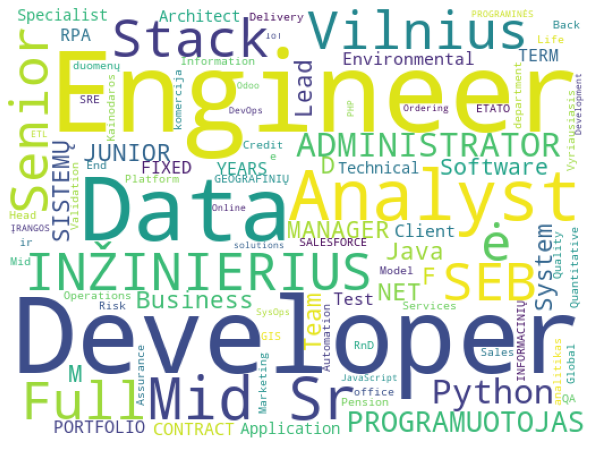

In [8]:
#@title Žodžių debesis

#@markdown Naudojamės wordcloud funcija.

# convert job titles
txt = " ".join(df_c.JobTitle).strip().title()

# generate word cloud
wordcloud = WordCloud(background_color = 'white',
                      width = 512,
                      height = 384).generate(" ".join(df_c.JobTitle))

# create figure object for word cloud
plt.subplots(figsize = (16,8))
plt.imshow(wordcloud) # image show
plt.axis('off'); # to off the axis of x and y

# Išsaugoti duomenis

Atkomentuoti eilutes su `CTR + /` ir išsaugoti norimu formatu. Failo pavadinimas sugenruojams:

* `cv_bankas_X.csv` arba `cv_bankas_X.xlsx`, kur `X` yra data, kad buvo paleistas kodas.

Norint atsisiųsti duomenis lokaliai paspauskite ant dešinėje pusė esančios "Files" ikonos ir atsisiųskite norimą failą. Jei to nepadarysite, failai bus ištrinti uždarius google colab.

![image info](https://i.stack.imgur.com/mYWnb.png)




In [9]:
# generate data for today
_date = pd.Timestamp.now().strftime("%Y_%m_%d")

# excel
# df_c.to_excel(f"cv_bankas_{_date}.xlsx", index = False)
# .csv
# df_c.to_csv(f"cv_bankas_{_date}.csv", index = False)